## 1.导入必要的工具包

In [1]:
import jieba
import joblib
import numpy as np
from random import shuffle
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Activation,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

## 2.读取文件

In [2]:
def read_txt(path,label):
    review_data = []
    labels = []
    f_pos = open(path, 'r', encoding='utf8')
    for line in f_pos:
        if line.strip('\n') is not None:
            tokens = list(jieba.cut(line))
            processed_sent = " ".join(tokens)
            review_data.append(processed_sent)
            labels.append(label)
    return review_data

# f_pos = open('data/pos.txt', 'r', encoding='utf8')
# for line in f_pos:
#     if line.strip('\n') is not None:
#         tokens = list(jieba.cut(line))
#         processed_sent = " ".join(tokens)
#         review_data.append(processed_sent)
#         labels.append(1)

# f_neg = open('data/neg.txt', 'r', encoding='utf8')
# for line in f_neg:
#     if line.strip('\n') is not None:
#         tokens = list(jieba.cut(line))
#         processed_sent = " ".join(tokens)
#         review_data.append(processed_sent)
#         labels.append(0)
# print(len(review_data))
# print(review_data[3], labels[3])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\shulin\AppData\Local\Temp\jieba.cache
Loading model cost 0.871 seconds.
Prefix dict has been built successfully.


3089
首先 说 一下 物流 ， 中午 十一点左右 下单 ， 下午 5 点多 就 到 了 ， 速度 真的 是 快 。 在 买 之前 ， 纠结 了 好久 ， 不 知道 到底 买多大 的 ， 最后 决定 买 32G 的 ， 毕竟 只是 作为 娱乐 工具 ， 够用 就 好 了 。 买回来 之后 用 了 几天 才 来 评价 ， 说实话 真的 是 很 好 。 反应速度 非常 快 ， 没有 卡顿 现象 ， 至于 屏幕 ， 个人感觉 并 没有 网上 的 那些 问题 ， 色泽 清晰 ， 鲜明 。 
 1


In [3]:
# avglen = 0 #句子最大长度
# len_list=[]
# for sent_str in review_data:
#     words=list(jieba.cut(sent_str))
#     length = len(words)
#     len_list.append(length)
#     avglen=np.sum(np.array(len_list))/len(len_list)
# print('avg_len:',avglen)

## 3.文本向量化

In [4]:
def txt_vectorize(text):
    tokenizer = Tokenizer() # 创建一个Tokenizer对象，将一个词转换为正整数
    tokenizer.fit_on_texts(text) #将词编号，词频越大，编号越小
    word2index = tokenizer.word_index
    # vocab_size=len(word2index)
    # index2word = {word2index[word]:word for word in word2index}
    x_word_ids = tokenizer.texts_to_sequences(text) #将句子中的每个词转换为数字
    x_padded_seqs = np.array(pad_sequences(x_word_ids,truncating='post',maxlen=100))#将每个句子设置为
    return x_padded_seqs

3089


## 4.构建模型

In [5]:
# 创建深度学习模型， Embedding + LSTM + Softmax.
def create_LSTM(n_units, input_size, output_dim,vocab_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size + 1, output_dim=output_dim,
    input_length=input_size, mask_zero=True))
    model.add(LSTM(n_units, input_shape=(None,input_size)))
    # model.add(Dropout(0.2))
    model.add(Dense(output_dim , activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

## 5.划分数据集和测试集

In [6]:
def split_data(x_padded_seqs,labels,K):  # 划分数据集和测试集
    if 0 < K <= 1:
        c = list(zip(x_padded_seqs,labels))
        shuffle(c) # 打乱顺序
        x_padded_seqs,labels, = zip(*c)
        x_padded_seqs, labels = list(x_padded_seqs)[0:int(len(x_padded_seqs)*K)],list(labels)[0:int(len(x_padded_seqs)*K)]
        return train_test_split(x_padded_seqs,labels,test_size=0.2,shuffle=0)
    else:
        x_padded_seqs = x_padded_seqs.tolist()
        c = list(zip(x_padded_seqs[0:K]+x_padded_seqs[-1900:],labels[0:K]+labels[-1900:]))  # 测试集
        d = list(zip(x_padded_seqs[K:-1900],labels[K:-1900]))                                 # 验证集
        shuffle(c)
        shuffle(d)
        x_padded_seqs,labels, = zip(*c)
        x_train = list(x_padded_seqs)
        y_train = list(labels)  # 打乱结果转换成列表
        x_padded_seqs1,labels1, = zip(*d)
        x_test = list(x_padded_seqs1)
        y_test = list(labels1)  # 打乱结果转换成列表
        return x_train,x_test,y_train,y_test
# print(len(x_padded_seqs))
# x_train,x_test,y_train,y_test=split_data(x_padded_seqs,labels,0.2)     # 测试集+训练集占比0.2
# x_train,x_test,y_train,y_test=split_data(x_padded_seqs,labels,0.5)     # 测试集+训练集占比0.5
# x_train,x_test,y_train,y_test=split_data(x_padded_seqs,labels,1)       # 测试集+训练集占比1
# x_train,x_test,y_train,y_test=split_data(x_padded_seqs,labels,860)     # 训练集+训练集数量为1900+860
# x_train,x_test,y_train,y_test=split_data(x_padded_seqs,labels,500)     # 训练集数量为1900+500
# x_train,x_test,y_train,y_test=split_data(x_padded_seqs,labels,100)     # 训练集数量为1900+100

#
# K = [0.2,0.5,1,860,500,100]
# for i in K:
#     x_train,x_test,y_train,y_test=split_data(x_padded_seqs,labels,i)
#     print(len(x_train))
#     print(len(x_test))
#     print(len(y_train))
#     print(len(y_test))
#     x_train=np.array(x_train)
#     x_test=np.array(x_test)
#     y_train=np.array(y_train)
#     y_test=np.array(y_test)
#     y_train_onehot=to_categorical(y_train)
#     y_test_hot=to_categorical(y_test)

## 6.训练并保存模型

In [15]:
def model_train(name):
    # 模型输入参数，需要自己根据需要调整
    input_size = txt_vectorize[1]
    print(input_size)
    n_units = 100
    batch_size = 32
    epochs = 50
    output_dim = 2
    # 模型训练
    lstm_model = create_LSTM(n_units, input_size, output_dim,vocab_size=vocab_size)
    lstm_model.fit(x_train, y_train_onehot, epochs=epochs, batch_size=batch_size, verbose=1)
    # joblib.dump(lstm_model,"models/Precision@"+name+'.model')
    results=lstm_model.predict(x_test)
    result_labels = np.argmax(results, axis=-1) # 获得最大概率对应的标签
    # print(type(result_labels))
    print('准确率', accuracy_score(y_test, result_labels))

    Precision = []
    correct = 0
    for i in range(len(result_labels)):
        if result_labels[i] == y_test[i]:
            correct += 1
        Precision.append(correct / (i + 1))
    num = [i+1 for i in range(len(result_labels))]
    plt.plot(num, Precision, c='red')
    # plt.scatter(num,Precision, c='red')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlabel("累计测试样本个数", fontdict={'size': 16})
    plt.ylabel("实时准确率", fontdict={'size': 16})
    plt.title("Precision@"+name, fontdict={'size': 20})
    plt.text(x=num[-1],y=Precision[-1],s='ACC:%.2f'%Precision[-1],fontsize=15)
    plt.savefig('figures/Precision@'+name+'.jpg')
    plt.show()

## 7.使用模型预测

In [16]:
# lstm_model = model_train()
# results=lstm_model.predict(x_test)
# result_labels = np.argmax(results, axis=-1) # 获得最大概率对应的标签
# # print(type(result_labels))
# print('准确率', accuracy_score(y_test, result_labels))

## 8.样本预测

In [17]:
# Precision = []
# correct = 0
# for i in range(len(result_labels)):
#     if result_labels[i] == y_test[i]:
#         correct += 1
#     Precision.append(correct / (i + 1))
# num = [i+1 for i in range(len(result_labels))]
# plt.plot(num, Precision, c='red')
# # plt.scatter(num,Precision, c='red')
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.xlabel("累计测试样本个数", fontdict={'size': 16})
# plt.ylabel("实时准确率", fontdict={'size': 16})
# plt.title('Precision', fontdict={'size': 20})
# plt.savefig('Precision.jpg')
# plt.show()

In [18]:
# mark = ['差评','好评']
# new_reviews=['体验不是很好，信号差还发烫。手机第一次充电就发烫的要死。热点总是自动打开','东西非常好，用起来也很方便，总之就很棒']
# new_sents=[]
# for sent_str in new_reviews:
#     tokens=jieba.cut(sent_str)
#     sent=' '.join(tokens)
#     new_sents.append(sent)
# x_new_ids = tokenizer.texts_to_sequences(new_sents) #将句子中的每个词转换为数字
# # print(x_new_ids[0])
# x_new_padseqs = pad_sequences(x_new_ids,truncating='post',maxlen=100)#将每个句子设置为
# # print(x_new_padseqs)
# # print(type(x_new_ids))
# probs=lstm_model.predict(x_new_padseqs)
# new_labels=np.argmax(probs,axis=-1)
# print(new_labels)
# for i in range(new_labels.shape[0]):
#     print(mark[new_labels[i]],end=' ')

493
124
493
124
100
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 2)            14480     
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               41200     
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 202       
Total params: 55,882
Trainable params: 55,882
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
16/16 [==============================] - 4s 38ms/step - loss: 0.6081 - accuracy: 0.6755
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.5518 - accuracy: 0.6917
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.5335 - accuracy: 0.6917
Epoch 4/50
16/16 [==============================] - 1s 39ms/st

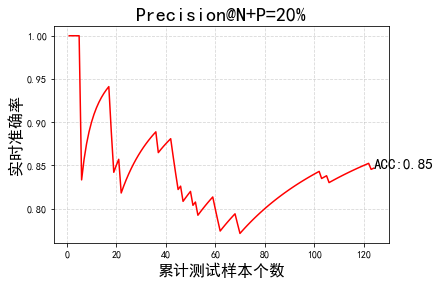

1235
309
1235
309
100
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 2)            14480     
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               41200     
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 202       
Total params: 55,882
Trainable params: 55,882
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
39/39 [==============================] - 5s 41ms/step - loss: 0.5891 - accuracy: 0.6704
Epoch 2/50
39/39 [==============================] - 2s 43ms/step - loss: 0.5464 - accuracy: 0.6810
Epoch 3/50
39/39 [==============================] - 2s 43ms/step - loss: 0.4406 - accuracy: 0.8680
Epoch 4/50
39/39 [==============================] - 2s 50ms/

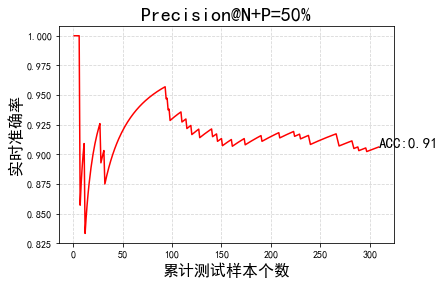

2471
618
2471
618
100
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 2)            14480     
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               41200     
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 202       
Total params: 55,882
Trainable params: 55,882
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
78/78 [==============================] - 7s 47ms/step - loss: 0.5575 - accuracy: 0.6864
Epoch 2/50
78/78 [==============================] - 4s 52ms/step - loss: 0.3957 - accuracy: 0.8673
Epoch 3/50
78/78 [==============================] - 5s 58ms/step - loss: 0.2468 - accuracy: 0.9332
Epoch 4/50
78/78 [==============================] - 5s 59ms/

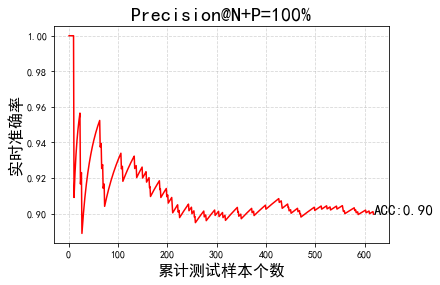

2760
329
2760
329
100
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 2)            14480     
_________________________________________________________________
lstm_17 (LSTM)               (None, 100)               41200     
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 202       
Total params: 55,882
Trainable params: 55,882
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
87/87 [==============================] - 7s 45ms/step - loss: 0.5466 - accuracy: 0.6993
Epoch 2/50
87/87 [==============================] - 5s 56ms/step - loss: 0.3564 - accuracy: 0.9083
Epoch 3/50
87/87 [==============================] - 5s 53ms/step - loss: 0.2043 - accuracy: 0.9420
Epoch 4/50
87/87 [==============================] - 5s 56ms/

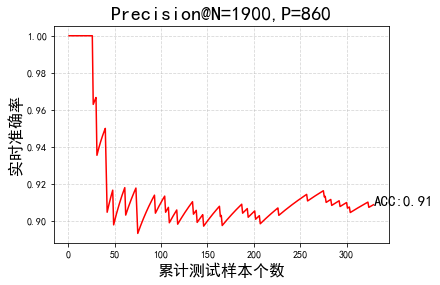

2400
689
2400
689
100
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 2)            14480     
_________________________________________________________________
lstm_18 (LSTM)               (None, 100)               41200     
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 202       
Total params: 55,882
Trainable params: 55,882
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
75/75 [==============================] - 5s 38ms/step - loss: 0.4737 - accuracy: 0.7871
Epoch 2/50
75/75 [==============================] - 3s 42ms/step - loss: 0.3521 - accuracy: 0.8558
Epoch 3/50
75/75 [==============================] - 3s 44ms/step - loss: 0.2106 - accuracy: 0.9413
Epoch 4/50
75/75 [==============================] - 3s 43ms/

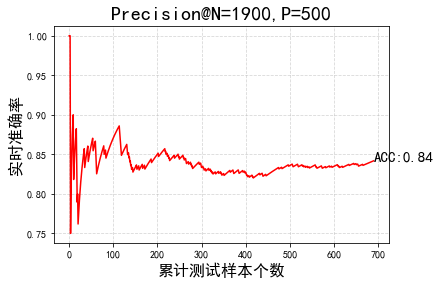

2000
1089
2000
1089
100
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 100, 2)            14480     
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               41200     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 202       
Total params: 55,882
Trainable params: 55,882
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
63/63 [==============================] - 6s 43ms/step - loss: 0.3028 - accuracy: 0.9445
Epoch 2/50
63/63 [==============================] - 3s 49ms/step - loss: 0.1916 - accuracy: 0.9500
Epoch 3/50
63/63 [==============================] - 3s 53ms/step - loss: 0.1723 - accuracy: 0.9505
Epoch 4/50
63/63 [==============================] - 4s 56m

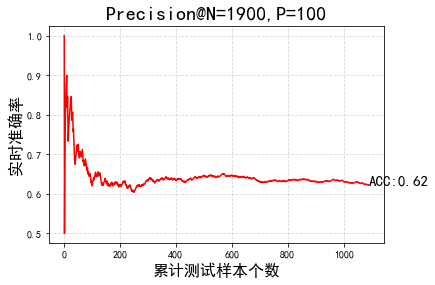

In [19]:
if __name__ == "__main__":
    K = [0.2,0.5,1,860,500,100]
    name = ['N+P=20%','N+P=50%','N+P=100%','N=1900,P=860','N=1900,P=500','N=1900,P=100']
    for i in range(6):
        x_train,x_test,y_train,y_test=split_data(x_padded_seqs,labels,K[i])
        print(len(x_train))
        print(len(x_test))
        print(len(y_train))
        print(len(y_test))
        x_train=np.array(x_train)
        x_test=np.array(x_test)
        y_train=np.array(y_train)
        y_test=np.array(y_test)
        y_train_onehot=to_categorical(y_train)
        y_test_hot=to_categorical(y_test)
        model_train(name[i])